In [1]:
import sys
sys.path.append(r"C:/Users/bgh19/OneDrive/Coding/GithubRepos/f3ast")
import f3ast
import numpy as np
import matplotlib.pyplot as plt
import trimesh.grouping as tg



In [2]:

settings = {}
settings["structure"] = {"pitch": 3, "fill": False}  # in nm
settings["stream_builder"] = {
    "addressable_pixels": [65536, 56576],
    "max_dwt": 5,  # in ms
    "cutoff_time": 0.01,  # in ms, for faster exporting: remove dwells below cutoff time
    "screen_width": 10.2e3,  # in nm, horizontal screen width / field of view
    # 'serpentine' or 'serial', scanning order between slices
    "scanning_order": "serpentine",
}
# pixel size for thermal resistance
settings["dd_model"] = {"single_pixel_width": 50}

## Import and modify `stl` structure

In [4]:
file_path = "branchtrio-SizedUp.stl"
struct = f3ast.Structure.from_file(file_path, **settings["structure"])

# rotate: specify axis and angle in degrees
# this is for example useful if FEBID growth is done with a tilted SEM sample stage
rotation_axis, rotation_angle = (0, 0, 0), (30)
struct.rotate(rotation_axis, rotation_angle)

struct.centre()  # centers xy to zero and sets minimum z value to zero
struct.rescale(.1)  # scale the structure 3x

print(struct.bounds)
# interactive plot for inspection
struct.show()

[[-460.36068124 -390.83102637    0.        ]
 [ 326.65801993  452.4265664  1772.40078125]]


## Define the growth model

For the two main growth models - RRL (reaction-rate limited growth) with constant dwell time in height, and DD (desorption-dominated growth), for which the dwell time are modified taking into account increasing thermal resistance with structure length and height.

In [84]:
GR0 = 0.200 # in um/s, base growth rate
k = 1.25 # in 1/nm?, thermal conductivity 
sigma = 4 # in nm, dwell size

# simple model, without thermal correction
# model = f3ast.RRLModel(struct, GR0, sigma)

# with correction due to thermal conductivity
model = f3ast.DDModel(struct, GR0, k, sigma, **settings['dd_model'])

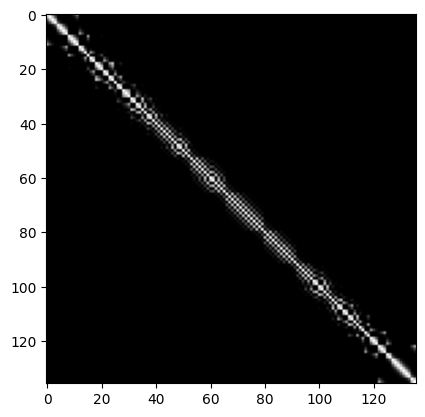

In [98]:
proxmat = model.get_proximity_matrix(800)
plt.imshow(proxmat.toarray())

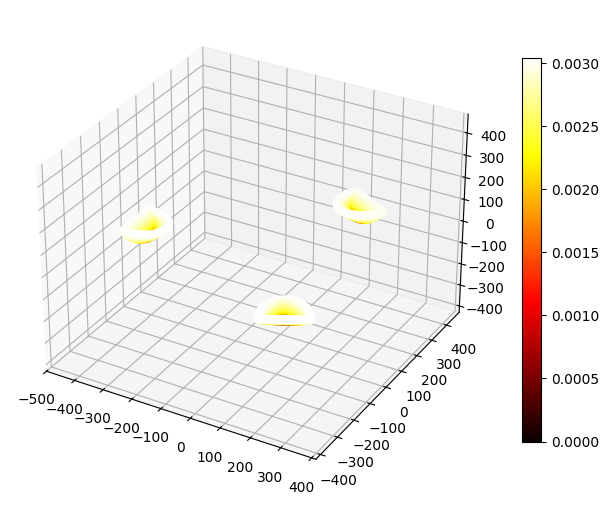

In [82]:
# plot thermal resistance for a check
# %matplotlib tk
point_min = 0
point_max = 10000




ax = struct.plot_point_range(point_min, point_max, c=np.concatenate(model.resistance)[point_min:point_max], cmap="hot")


## Resistance Analysis:

: 

## Solve for dwells and inspect

Solving for dwells...
Solved
Total stream time:  0:11:43.827716


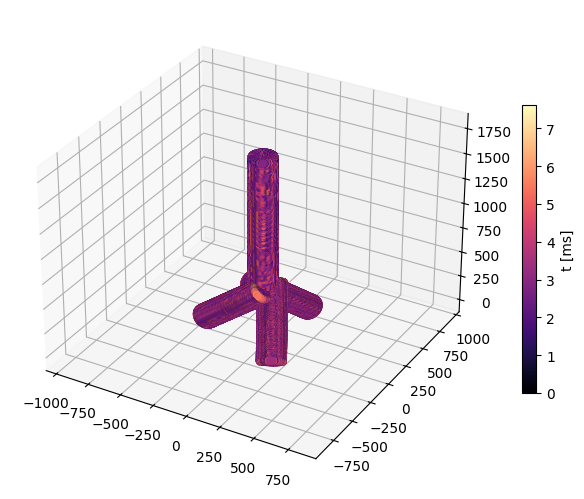

In [8]:
stream_builder, dwell_solver= f3ast.StreamBuilder.from_model(model, **settings['stream_builder'])


dwell_solver.print_total_time()

# inspect dwells 
ax, sc = dwell_solver.show_solution()

Mean: 2.27 
 Median: 2.31 
 Max: 6.680536642903367 
 Min: 1.0075105688241824e-07


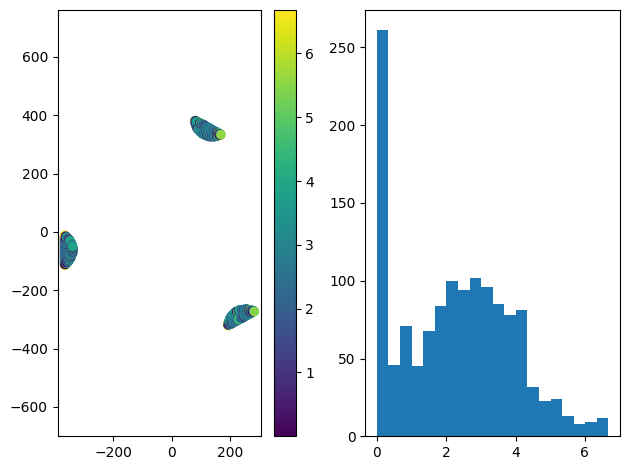

In [83]:

dwell_list = dwell_solver.get_dwells_slices()
### Get dwells by layer. dwell_layers is a list of length n_layers, with each entry being a numpy array of shape (NumPoints, 4). Each point is associated with x,y,z,dwell.
min_layer = 0
max_layer = min_layer+10
dwell_layers = np.concatenate(dwell_list[min_layer:max_layer])


data = dwell_layers[:,:]
dwells = data[:,0]

fig, ax = plt.subplots(1, 2, tight_layout=False)
data_plot = ax[0].scatter(data[:,1], data[:,2], c=dwells, cmap='viridis')
plt.colorbar(data_plot, ax=ax[0])
ax[0].axis('equal')

ax[1] = plt.hist(dwells, bins = 20)
npmean = np.mean(dwells)
npmed = np.median(dwells)
npmax = np.max(dwells)
npmin = np.min(dwells)
print(f"Mean: {npmean:.2f} \n Median: {npmed:.2f} \n Max: {npmax} \n Min: {npmin}")


In [7]:
intersection_lines, zlev = struct.get_intersection_lines()

gen_slice = struct.generate_slices()

Slicing...
Sliced


The solver process for f3ast goes like this:

1. f3ast loads the STL file and creates a Trimesh object from it.
    > struct = f3ast.Structure.from_file(file_path, **settings["structure"])

2. The Structure module slices the trimesh object and obtains lines that approximate the surface at each layer. This is done using trimesh's mesh_multiplane. The resulting data is made up of a ton of lines at each z height.

3. The split_intersection function is called from branches module, which uses the trimesh group_rows to combine the points at the same locations. This essentially connects the lines into "branches". This gets stored as branch_intersections_slices for all the slices. The lines make up the __surface__ of the structure, which I think is our problem.

4. The branch connections to subsequent layers is then calculated.

4. The deposit_model module 
    > model = f3ast.DDModel(struct, GR0, k, sigma, **settings['dd_model'])  

5. Stream_builder module creates StreamBuilder class with the from_model function.  This initializes by calling DwellSolver, from the solver module.
    > stream_builder, dwell_solver = f3ast.StreamBuilder.from_model(model, **settings['stream_builder'])

6. 
    

The cell below will display a single slice of the dwell_layer, showing only the x and y points that the dwell is calculated for.

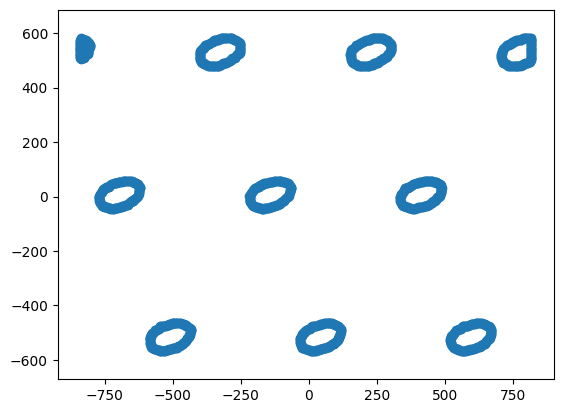

In [ ]:
### Force the structures to be smaller
for m in range(20,21):
    n = dwell_layers[m]
    dwell_slice = np.asarray(n)
    data = dwell_slice[:, :3]
    positions = data[:,:]
    # print(positions.shape)
    # print(data[:,2])
    # print(data[:,1])
    fig, ax = plt.subplots()
    ax.scatter(data[:,1], data[:,2])
    ax.axis('equal')



## Export stream files

Depending on the interface of the SEM/dual beam you are working with, the visible name of the stream file might be very short (e.g., 18 characters only for the Helios 600). In this case, it makes sense to keep a short filename, and/or put the most important pieces of information of the pattern into the beginning.

It can be helpful to also add the total writing time for an exported stream at the end, see example below how to create a descriptive filename from patterning parameters.

In [33]:
# get stream
strm = stream_builder.get_stream()

# export with simple name
out_filename = "IWP_model_v3_200gr_3k_4sig_p3"
strm.write(f"{out_filename}.str")

# this is an example on how to build a descriptive filename
# e.g. with growth rate GR0 in nm/s, and total writing time in seconds
# total_time = f"{strm.get_time().seconds}.{strm.get_time().microseconds/1e5:.0f}s"
# out_filename = f"stream_test-GR{GR0*1e3:.0f}-{total_time}"
print(out_filename)

IWP_model_v3_200gr_3k_4sig_p3
